In [15]:
#Modules to install via pip pandas,ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pprint import pprint
import os
import import_ipynb
import sys
import kmeans
sys.path.append('../')
from functions import *
from trace_analysis import *
from plots import *
from trace_analysis_cooja2 import *
from node import *
from plots_analysis import *
from pandas.plotting import scatter_matrix
import cmath as math
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
# scipy
from scipy.cluster.vq import kmeans,vq,whiten
import sklearn.metrics as sm
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline
import random
random.seed(6666)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from node import *


#Import for Kmeans

def import_Cooja2(plots):
    data=[]
    node_defaults = {
        "aaaa::212:7403:3:303": 1,
        "aaaa::212:7402:2:202": 2,
        "aaaa::212:7404:4:404": 2,
        "aaaa::212:7406:6:606": 2,
        "aaaa::212:7405:5:505": 3,
        "aaaa::212:7407:7:707": 3,
        "aaaa::212:7409:9:909": 3,
        "aaaa::212:7408:8:808": 4,
        "aaaa::212:740a:a:a0a": 4}
    for row in plots:

        #print("Importing ./"+row[0]+"/"+row[1])
        nodeList=import_nodes_Cooja_2(row[0],row[1],node_defaults)
        data.append(nodeList)

    return data
def import_nodes_Cooja_2(directory,tracemask,node_defaults):
    #print(directory)
    #print(tracemask)
    files = []

    # load all files and extract IPs of nodes
    for file in os.listdir(directory):
        try:
            if file.startswith(tracemask) and file.index("routes"):
                continue
        except:
            files.append(file)

    nodes = pd.DataFrame(columns=['node_id', 'rank'])
    packets_node = {}

    # Load the ICMP traces
    for file in files:
        packets = pd.read_csv(directory + '/' + file,
                              sep=' |icmp_seq=|ttl=|time=',
                              na_filter=True,
                              header=None,
                              skiprows=1,
                              skipfooter=4,
                              usecols=[3, 5, 7, 9],
                              names=['node_id', 'seq', 'hop', 'rtt'],
                              engine='python').dropna().drop_duplicates()

        if len(packets) < 1:
            # Nodes affected by a black hole did not receive any packet
            node_id = file[-24:-4]
            packets = pd.DataFrame(columns=['node_id', 'seq', 'hop', 'rtt'],
                                   data=[[node_id, 1, node_defaults[node_id], 1]])

            nodes.loc[len(nodes)] = [file[-24:-4], node_defaults[node_id]]
            packets_node[file[-24:-4]] = packets

        else:
            packets['node_id'] = packets.apply(lambda row: row['node_id'][:-1], axis=1)

            nodes.loc[len(nodes)] = [packets['node_id'][0], 64 - packets['hop'][0]]

            packets = packets.sort_values(by=['node_id', 'seq'], ascending=True, na_position='first')
            packets = packets[packets['rtt'] > 1]

            packets_node[packets['node_id'][0]] = packets

    #tranformation in node
    nodeList=[]

    for n in packets_node.keys():
        #print((packets_node[n]).head())
        pkts=packets_node[n].drop(["node_id","hop"],axis=1)
        #print(pkts)
        hop=int(packets_node[n]["hop"][0])
        ip=packets_node[n]["node_id"][0]
        n=node(ip,hop,pkts)
        nodeList.append(n)


    return nodeList




#End functions from cooja2 -> nodes for kmeans


In [18]:
directory="../cooja3-9nodes/"
plots = [
        (directory+"traces/1bh-3", 'grid9_1bh-3_2019-02-13_16:28_'),
         (directory+"traces/1bh-5", 'grid9_1bh-5_2019-02-13_15:31_'),
         (directory+"traces/1bh-6", 'grid9_1bh-6_2019-02-13_12:59_'),
         (directory+"traces/1bh-7", 'grid9_1bh-7_2019-02-13_15:08_'),
         (directory+"traces/1bh-9", 'grid9_1bh-9_2019-02-13_15:57_'),
         
         (directory+"traces/normal", 'grid9_normal_2019-02-13_17:05_')
        ]

print(directory)
cases=[
    'grid9_1bh-3_2019-02-13_16:28_',
    'grid9_1bh-5_2019-02-13_15:31_',
     'grid9_1bh-6_2019-02-13_12:59_',
     'grid9_1bh-7_2019-02-13_15:08_',
      'grid9_1bh-9_2019-02-13_15:57_',
      'grid9_normal_2019-02-13_17:05_'
]


casesAccuracy=[
    "BH",
    "BH",
    "BH",
    "BH",
    "BH",
    "normal"
]

data=import_Cooja2(plots)



../cooja3-9nodes/


In [31]:
print(data[0][0].pkts)

   seq  rtt
0    1    1


In [27]:
pings=getPings(data)
#All data collection is in variable node that is a list of list of nodes
#3 nets input x 9 nodes by net

d={ "label":[],
   "type":[],
    "count":[],
    "std":  [],
    "mean": [],
    "var":  [],
    #"25%":  [],
    #"50%":[],
    #"75%":[],
   #"min":[],
   #"max":[],
   "hop":[],
   #"missing":[],
   "packet loss":[],
   "outliers":[],
   "node":[]
}
#count=[]
labels=[]
var=[]
#window=100
#stats=pd.DataFrame(columns=columns)

for i in range(len(data)):
    #window=pings[i]
    
    for j in range(len(data[i])):
        #n=pings[i]
        n=100
        window=100
        #print(n)
        for z in range(0,n,int(window)):
            #if(z+window>n):break
            #print(z,z+window)
            
            #df1 = df1.assign(e=p.Series(np.random.randn(sLength)).values)
            node=data[i][j].pkts
            name=str(j)+" "+cases[i]
            nodeWindow=node[(node["seq"]<z+window) & (node["seq"]>=z)]
            
            nodeWindowP=nodeWindow["rtt"]
            #df1 = df1.assign(e=p.Series(np.random.randn(sLength)).values)
            #if(nodeWindowP.count()<window/2): break
            #current=data[i][j].pkts['rtt'][z:z+window]
            #print(nodeWindow.shape)
            d["count"].append(nodeWindowP.count())
            #Case without outliers
            #d["std"].append(getStdValues(data[i][j].pkts)["rtt"].std())

            #Case with outliers
            d["std"].append(nodeWindowP.std())

            d["mean"].append(nodeWindowP.mean())
            d["var"].append(nodeWindowP.var())
            d["label"].append(cases[i])
            #d["25%"].append(nodeWindow.describe()["25%"])
            #d["50%"].append(nodeWindow.describe()["50%"])
            #d["75%"].append(nodeWindow.describe()["75%"])
            #d["min"].append(nodeWindow.describe()["min"])
            #d["max"].append(nodeWindow.describe()["max"])
            d["hop"].append(data[i][j].hop)
            d["type"].append(casesAccuracy[i])
            d["outliers"].append(getOutliers(nodeWindow)["rtt"].count())
            missing=window-nodeWindow.count()
            d["node"].append(data[i][j].ip)
            d["packet loss"].append(getPercentageMissingPackets(nodeWindow,window))

            
            
stats=pd.DataFrame(d)            


        

#correction=np.array(correction)
#correction_alt=np.array(correction_alt)

dataK=stats.drop([
    "label",
    #"mean",
    "var","std",
    #"packet loss",
    "outliers",
    "hop",
    "count","node",
    #"type"
],axis=1)
print(dataK)  
print(dataK.shape)
dataK=dataK.dropna()
print(dataK.shape)
      

      type        mean  packet loss
0       BH    1.000000         99.0
1       BH    1.000000         99.0
2       BH    1.000000         99.0
3       BH    1.000000         99.0
4       BH    1.000000         99.0
5       BH    1.000000         99.0
6       BH    1.000000         99.0
7       BH    1.000000         99.0
8       BH  167.360215          7.0
9       BH  247.228261          8.0
10      BH  375.350000         20.0
11      BH  197.289286         16.0
12      BH  233.820238         16.0
13      BH   92.465116         14.0
14      BH  419.256757         26.0
15      BH  167.169474          5.0
16      BH  276.800000         20.0
17      BH  319.217391         31.0
18      BH   99.150704         29.0
19      BH  194.752941         15.0
20      BH   91.576289          3.0
21      BH  249.677419          7.0
22      BH  139.049296         29.0
23      BH  217.926471         32.0
24      BH    1.000000         99.0
25      BH  292.492958         29.0
26      BH  123.213043      

In [28]:




correction=[]
correction_alt=[] #fr 3 cluster 0:normal net 1:bh net 2:bh
col=np.array(dataK["type"])
dataK=dataK.drop(["type"],axis=1)
#Creating simple array to correct unsupervised learning
#NB as it is unsupervised could happen that the correction are inverted
for i in range(len(col)):
    el=d["type"][i]
    if el=="normal":
        correction.append(1)
        correction_alt.append(0)
        
    else:
        #print(el=="BH2" and i==BlackHole[2])
        correction.append(0)
        correction_alt.append(1)
                        

dataC=stats["label"]

#Y = data[['var']]
#X = data[['std']]

kmeans = KMeans(n_clusters=2)
kmeans.fit(dataK)
labels = kmeans.predict(dataK)
centroids = kmeans.cluster_centers_
labels=accuracy_score_corrected(correction,labels)
predicted=[]
for i in range(len(labels)):
    
    if(labels[i]==1):
        predicted.append("normal")
    else: predicted.append("BH")

#print(len(predicted))
stats["predicted"]=pd.Series(np.array(predicted))
stats["predicted number"]=pd.Series(np.array(labels))
stats["correction number"]=pd.Series(np.array(correction))
stats_csv=stats[[
    "label",
    "type",
    "predicted",
    #"packet loss",
    "outliers",
    "std",
    "hop",
    "node"
      
      
      ]]
#stats_csv.to_csv("results_kmeans.csv", sep='\t', encoding='utf-8')
stats.head()


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
0.6296296296296297
[0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0
 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1]
array([[26, 19],
       [ 1,  8]])


,label,type,count,std,mean,var,hop,packet loss,outliers,node,predicted,predicted number,correction number
0,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.0,NaN,4,99.0,0,aaaa::212:7408:8:808,BH,0,0
1,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.0,NaN,3,99.0,0,aaaa::212:7407:7:707,BH,0,0
2,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.0,NaN,2,99.0,0,aaaa::212:7402:2:202,BH,0,0
3,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.0,NaN,2,99.0,0,aaaa::212:7406:6:606,BH,0,0
4,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.0,NaN,3,99.0,0,aaaa::212:7409:9:909,BH,0,0


In [123]:
stats

,label,type,count,std,mean,var,hop,packet loss,outliers,node,predicted,predicted number,correction number
0,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,4,99.462366,0,aaaa::212:7408:8:808,normal,1,0
1,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,3,99.462366,0,aaaa::212:7407:7:707,normal,1,0
2,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,2,99.462366,0,aaaa::212:7402:2:202,normal,1,0
3,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,2,99.462366,0,aaaa::212:7406:6:606,normal,1,0
4,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,3,99.462366,0,aaaa::212:7409:9:909,normal,1,0
5,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,4,99.462366,0,aaaa::212:740a:a:a0a,normal,1,0
6,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,2,99.462366,0,aaaa::212:7404:4:404,normal,1,0
7,grid9_1bh-3_2019-02-13_16:28_,BH,1,NaN,1.000000,NaN,3,99.462366,0,aaaa::212:7405:5:505,normal,1,0
8,grid9_1bh-3_2019-02-13_16:28_,BH,171,133.555910,132.687135,17837.181010,63,8.064516,7,aaaa::212:7403:3:303,BH,0,0
9,grid9_1bh-5_2019-02-13_15:31_,BH,187,124.305505,210.256684,15451.858490,61,4.591837,8,aaaa::212:7405:5:505,BH,0,0


In [29]:
net_results={
   "case":[],
    "predicted":[],
    "real":[]
}
#print(stats["predicted number"])
for case in range(len(cases)):
    subset=stats[stats["label"]==cases[case]]
    mean_predicted=str(subset["predicted number"].mean()*100)+"% normal"
    net_results["case"].append(cases[case])
    net_results["predicted"].append(mean_predicted)
    net_results["real"].append(casesAccuracy[case])

    
results=pd.DataFrame(net_results)  

results

,case,predicted,real
0,grid9_1bh-3_2019-02-13_16:28_,0.0% normal,BH
1,grid9_1bh-5_2019-02-13_15:31_,66.66666666666666% normal,BH
2,grid9_1bh-6_2019-02-13_12:59_,33.33333333333333% normal,BH
3,grid9_1bh-7_2019-02-13_15:08_,55.55555555555556% normal,BH
4,grid9_1bh-9_2019-02-13_15:57_,55.55555555555556% normal,BH
5,grid9_normal_2019-02-13_17:05_,88.88888888888889% normal,normal


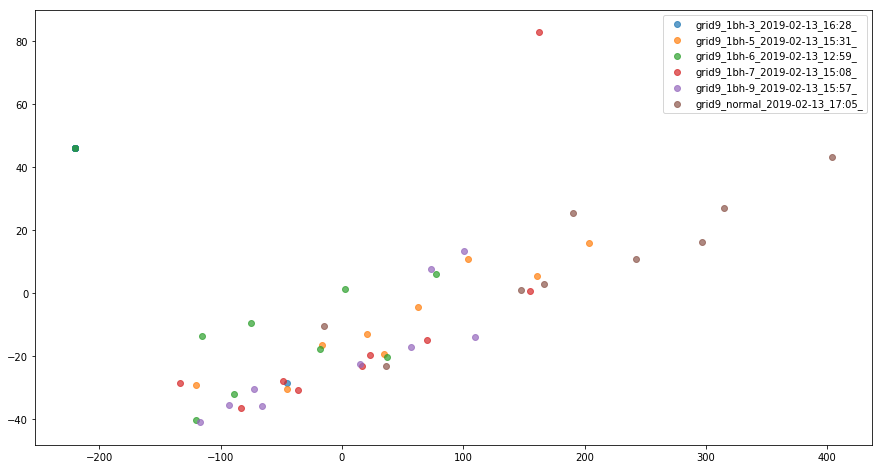

In [30]:
X = dataK.iloc[:,0:4]
pca = PCA(n_components=2)
pca.fit(X)
X_ = pca.transform(X)

dfPCA = pd.DataFrame({'x1': X_[:,0], 'x2': X_[:,1]})
dfPCA['labels'] = stats['label']
dfPCA.head()

labels = stats['label'].unique().tolist()
plt.figure(figsize=(15,8))
for lab in labels:
    plt.scatter(dfPCA.loc[dfPCA['labels'] == lab, 'x1'],  dfPCA.loc[dfPCA['labels'] == lab, 'x2'], label=lab, alpha=0.7)
    plt.legend()